In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import warnings
import tensorflow as tf
from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Activation, Lambda, Add, concatenate, Reshape,DepthwiseConv2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras import initializers, regularizers, constraints
from keras.utils import conv_utils, layer_utils
from keras.utils.io_utils import HDF5Matrix
from keras.engine.topology import Layer
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras.applications import imagenet_utils
from keras.applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import keras

import numpy as np
import h5py
from sklearn.model_selection import train_test_split

%matplotlib inline
from matplotlib import pyplot as plt

# Own module
import sys
sys.path.append("../utils/")
from utils import smoothL1, relu6
#from layers import DepthwiseConv2D

INPUT_SHAPE = (64, 64, 1)
OUTPUT_SIZE = 136
N_LANDMARK = 68

Using TensorFlow backend.


In [3]:
def facial_landmark_cnn(input_shape=INPUT_SHAPE, output_size=OUTPUT_SIZE):
    # Stage 1 #
    img_input = Input(shape=input_shape)
    
    ## Block 1 ##
    x = Conv2D(32, (3,3), strides=(1,1), name='S1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv1')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='S1_pool1')(x)

    ## Block 2 ##
    x = Conv2D(64, (3,3), strides=(1,1), name='S1_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv2')(x)
    x = Conv2D(64, (3,3), strides=(1,1), name='S1_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv3')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='S1_pool2')(x)

    ## Block 3 ##
    x = Conv2D(64, (3,3), strides=(1,1), name='S1_conv4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv4')(x)
    x = Conv2D(64, (3,3), strides=(1,1), name='S1_conv5')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv5')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='S1_pool3')(x)
        
    ## Block 4 ##
    x = Conv2D(256, (3,3), strides=(1,1), name='S1_conv8')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv8')(x)
    x = Dropout(0.2)(x)
    
    ## Block 5 ##
    x = Flatten(name='S1_flatten')(x)
    x = Dense(2048, activation='relu', name='S1_fc1')(x)
    x = Dense(output_size, activation=None, name='S1_predictions')(x)
    model = Model([img_input], x, name='facial_landmark_model')
    
    return model

In [8]:
x_data = HDF5Matrix('Tool.h5', 'image')    # 위에서 생성한 HDF5 파일의 image 경로의 데이터를 가져오게 된다.

(229, 3, 1920, 1080)
[[[201. 228. 249. ...  13.  13.  13.]
  [255. 255. 255. ...  13.  13.  13.]
  [255. 255. 255. ...  13.  13.  13.]
  ...
  [118. 136. 134. ...  69.  73.  78.]
  [118. 136. 134. ...  73.  88.  48.]
  [118. 136. 134. ...  92. 113.  22.]]

 [[191. 218. 239. ...  11.  11.  11.]
  [255. 255. 255. ...  11.  11.  11.]
  [255. 255. 255. ...  11.  11.  11.]
  ...
  [ 48.  66.  64. ...  59.  63.  67.]
  [ 48.  66.  64. ...  63.  78.  38.]
  [ 48.  66.  64. ...  81. 102.  11.]]

 [[171. 198. 219. ...  16.  16.  16.]
  [245. 255. 255. ...  16.  16.  16.]
  [235. 251. 254. ...  16.  16.  16.]
  ...
  [ 42.  59.  57. ...  48.  51.  56.]
  [ 42.  59.  57. ...  51.  66.  27.]
  [ 42.  59.  57. ...  70.  91.   0.]]]
(3, 1920, 1080)
(1080, 1920, 3)


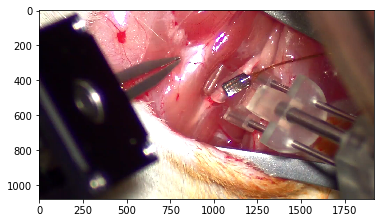

In [16]:
print(x_data.shape)
img = x_data[0]
print(img)
print(img.shape)
cur_img = np.zeros([1080,1920,3])
for i in range(0,3):
    cur_img[:,:,i] = np.transpose(img[i,:,:])

print(cur_img.shape)
cur_img = cur_img.astype('uint8')
plt.imshow(cur_img)

In [ ]:
x_train = HDF5Matrix(filename, 'image', end=split_pos)    # HDF5 파일의 데이터 중 일부만 가져오는 것도 가능하다. 
x_test = HDF5Matrix(filename, 'image', start=split_pos)
y_train = HDF5Matrix(filename, 'label', end=split_pos)
y_test = HDF5Matrix(filename, 'label', start=split_pos)

In [3]:

#        Define X and y
# #        Load data
#PATH = "./data/64_64_1/offset_1.3/"
#X = np.load(PATH + "basic_dataset_img.npz")
#y = np.load(PATH + "basic_dataset_pts.npz")
X = np.load("basic_dataset_img.npz")
y = np.load("basic_dataset_pts.npz")
X = X['arr_0']
y = y['arr_0'].reshape(-1, 136)


print("Define X and Y")
print("=======================================")

# Split train / test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Success of getting train / test dataset")
print("=======================================")
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("=======================================")
        

Define X and Y
Success of getting train / test dataset
X_train:  (89688, 64, 64, 1)
y_train:  (89688, 136)
X_test:  (22423, 64, 64, 1)
y_test:  (22423, 136)


In [4]:
model = facial_landmark_cnn(X_train.shape[1:4], y_train.shape[1])
model.compile(loss=smoothL1, optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['mape'])
print(model.summary())
# checkpoint
#filepath="./basic_checkpoints/smooth_L1-{epoch:02d}-{val_mean_absolute_percentage_error:.5f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]
# history = model.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True,\
#                     verbose=1, validation_data=(X_test, y_test), callbacks=callbacks_list)

history = model.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True,\
                    verbose=1, validation_data=(X_test, y_test))
# Save model
model.save("./model/face_landmark_dnn.h5")
print("=======================================")
print("Save Final Model")
print("=======================================")
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
S1_conv1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
S1_relu_conv1 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
S1_pool1 (MaxPooling2D)      (None, 31, 31, 32)        0         
_________________________________________________________________
S1_conv2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 64)        256       
__________

89688/89688 [==============================] - 33s 363us/step - loss: 0.4610 - mean_absolute_percentage_error: 2.0675 - val_loss: 0.4345 - val_mean_absolute_percentage_error: 1.9208oss: 0.4552 - mean_absolute_percentage_error: 2. - ETA: 27s - loss: 0.4598 - mean_abso - ETA: 25s - loss: 0.4572 - mean_absolute_percentage_er - ETA: 24s - loss: 0.4547 - mean_a - ETA: 22s - loss: 0.4593 - mean_absolute_percentage_err - ETA: 21s - loss: 0.4598 - ETA: 19s - los - ETA: 16s - loss: 0.4614 - mean_absolute_percentage_error: 2 - ETA: 15s - loss: 0.4607 - mean_absolute_percentage_error:  - ETA: 15s - loss: 0.4613 - mea - ETA: 13s - loss: 0.4629 - mean_absolute_percentage_error: 2.069 - ETA: 13s - loss: - ETA: 10s - loss: 0.4618 - mean_absolute_percentage_er - ETA: 9s - loss: 0 - ETA: 8s - loss: - ETA:  - ETA: 2s - loss: 0.4605 - mean_absolute_ - ETA: 1s - loss: 0.4608 - mean_absolute_percenta - ETA: 1s - loss: 0.4603 - mean_absolute_percenta - ETA: 0s - loss: 0.4605 - mean_absol
Epoch 31/100
89688/

89688/89688 [==============================] - 33s 363us/step - loss: 0.3874 - mean_absolute_percentage_error: 1.9096 - val_loss: 0.3923 - val_mean_absolute_percentage_error: 1.7954- ETA: 24s - loss: 0.3840 - mean_absolute_percentage_error - ETA: 24s - loss: 0.3872 - mean_absolute_percentage_error - ETA: 23s - loss: 0.3876 - mean_abso - ETA: 21s - loss: 0.3845 - mean_abso - ETA: 19s - loss: 0.3862 - mean_absolute_percentage_error:  - ETA: 19s - loss: 0.3861 - mean_absolute_percentage_error - ETA: 19s - loss: 0.3856 - mean_absolute_percentage_error: 1. - ETA: 18s - loss: 0.3850 - mean_absolute_percentage_error: 1.901 - ETA: 18s - loss: 0.3849 - mean_absolute_percentage_erro - ETA: 18s - loss: 0.3853 - mean_absolute_percentage_error - ETA: 17s - loss: 0.3848 - mean_absolute_percen - ETA: 16s - loss: 0.3845 - mean_absolute_percentage_error:  - ETA: 16s - loss: 0.3844 - mean_absolute_percentage_error: 1.902 - ETA: 15s - loss: 0.384 - ETA: 13s - loss: 0.3837 - mean_absolute_percentage_error

89688/89688 [==============================] - 32s 360us/step - loss: 0.3579 - mean_absolute_percentage_error: 1.8380 - val_loss: 0.3994 - val_mean_absolute_percentage_error: 1.8344solute_percentage_error: 1.834 - ETA: 25s - loss: 0.3563 - mean_absolute_percentage_error:  - ETA: 24s - loss: 0.3589 - mean_absolute_percentage_error - ETA: 24s - loss: 0.3594 - - ETA: 13s - loss: 0.3586 - mean_absolute_percenta - ETA: 12s - loss: 0.3585 - mean_absolute_percentage_e - ETA: 11s - loss: 0.3581 - mean_absolute_percentage_error: - ETA: 11s - loss: 0.3580 - mean_absolute_pe - ETA: 9s - loss: 0.3584 - mean_absolute_percentage_error - ETA: 9s - loss: 0.3581 - mean_absolute_percentage_error: 1. - ETA: 9s - loss: 0.3580 - mean_absolute_percen - ETA: 8s - loss: 0.3580  - ETA: 3s - loss: - E
Epoch 75/100
89688/89688 [==============================] - 32s 360us/step - loss: 0.3577 - mean_absolute_percentage_error: 1.8372 - val_loss: 0.3534 - val_mean_absolute_percentage_error: 1.6760e_percentage_err - 

OSError: Unable to create file (unable to open file: name = './model/face_landmark_dnn.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [5]:
# Save model
model.save("face_landmark_dnn.h5")
print("=======================================")
print("Save Final Model")
print("=======================================")

Save Final Model


In [6]:
model.predict(X_test)

array([[0.15695268, 0.3215161 , 0.13583708, ..., 0.67614204, 0.32246783,
        0.6675075 ],
       [0.1475805 , 0.2719211 , 0.17368883, ..., 0.66914237, 0.62465537,
        0.6720848 ],
       [0.14607053, 0.25084013, 0.1471796 , ..., 0.6665373 , 0.46518365,
        0.6604221 ],
       ...,
       [0.13960293, 0.24876657, 0.13553908, ..., 0.6212773 , 0.4290751 ,
        0.6142744 ],
       [0.09144589, 0.3860588 , 0.09776972, ..., 0.6498134 , 0.43863153,
        0.64699227],
       [0.13349909, 0.2836862 , 0.16020617, ..., 0.6585025 , 0.5462185 ,
        0.66054434]], dtype=float32)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


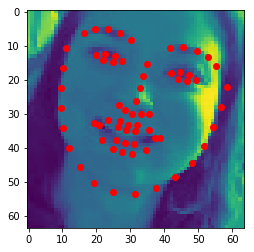

In [23]:

img_num = 10
img_test = X_test[img_num,:,:].reshape(64,64)

pts = model.predict(X_test)
pts = pts[img_num,:]
pts = pts.reshape(-1,2)

plt.imshow(img_test)
plt.scatter(pts[:,0]*64, pts[:,1]*64, c = [1,0,0])
plt.show()

In [20]:
pts = model.predict(X_test)
pts = pts[img_num,:]
pts = pts.reshape(-1,2)
pts.shape

(68, 2)